# Film Feedback Classificator with TensorFlow

Загрузка набора данных Reuters. Загружается только 10000 из 88585 уникальных слов, так как многие из них встречаются только в одном образце и поэтому не несут полезной информации для классификации. Всего имеется 8982 обучающих и 2246 контрольных примеров. По аналогии с отзывами в базе данных IMDB каждый пример — это список целых чисел (индексов слов). Метка, определяющая класс примера, — целое число между 0 и 45 — это индекс темы.

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

(train_data, train_labels), (test_data, test_labels) = keras.datasets.reuters.load_data(num_words=10000)

Декорирование новостей в текст.

In [2]:
word_index = keras.datasets.reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


Векторизовать метки можно двумя способами: сохранить их в тензоре целых чисел или использовать прямое кодирование. Прямое кодирование (one-hot encoding) широко используется для подготовки категорийных данных и также называется кодированием категорий (categorical encoding). В данном случае прямое кодирование меток заключается в конструировании вектора с нулевыми элементами и значением 1 в элементе, индекс которого соответствует индексу метки. В Keras уже реализован этот метод. Для кодирования входных данных можно использовать функцию vectorize_sequences.

In [3]:
def vectorize_sequences(sequences, dimension=20000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = keras.utils.to_categorical(train_labels)
y_test = keras.utils.to_categorical(test_labels)

Построение модели. Модель завершается слоем Dense размером 46. Это означает, что для каждого входного образца модель будет выводить 46-мерный вектор. Каждый элемент этого вектора (каждое измерение) представляет собой отдельный выходной класс. Последний слой использует функцию активации softmax. Этот шаблон означает, что модель будет выводить распределение вероятностей по 46 разным классам — для каждого образца на входе модель будет возвращать 46-мерный вектор, где output[i] — вероятность принадлежности образца классу i. Сумма 46 элементов всегда будет равна 1.

In [4]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(46, activation='softmax')
])

Компиляция модели. Лучшим претендентом на роль функции потерь в данном случае является функция categorical_crossentropy. Она определяет расстояние между распределениями вероятностей: в данном случае между распределением вероятности на выходе модели и истинным распределением меток. Минимизируя расстояние
между этими двумя распределениями, мы учим модель выводить результат, максимально близкий к истинным меткам.

In [5]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Создание проверочного набора.

In [6]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

Обучение модели.

In [7]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.3781 - loss: 3.1572 - val_accuracy: 0.6190 - val_loss: 1.8412
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6622 - loss: 1.6662 - val_accuracy: 0.6830 - val_loss: 1.3916
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7408 - loss: 1.2138 - val_accuracy: 0.7320 - val_loss: 1.2110
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7844 - loss: 1.0016 - val_accuracy: 0.7580 - val_loss: 1.1146
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8343 - loss: 0.8199 - val_accuracy: 0.7870 - val_loss: 1.0143
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8560 - loss: 0.6900 - val_accuracy: 0.7970 - val_loss: 0.9536
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8861 - loss: 0.5667 - val_accuracy: 0.8100 - val_loss: 0.9348
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9015 - loss: 0.4974 - val_accuracy: 0.7960 - val_loss

Формирование графиков потерь на этапах обучения и проверки

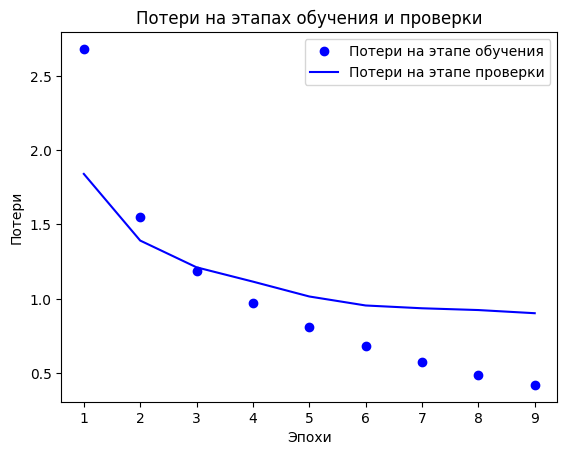

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

Формирование графиков точности на этапах обучения и проверки

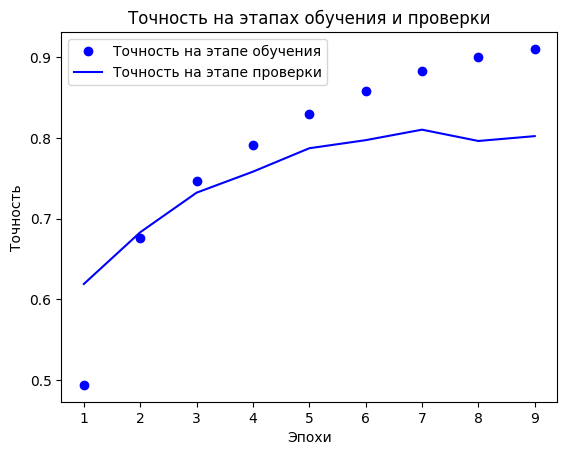

In [9]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Точность на этапе обучения')
plt.plot(epochs, val_acc, "b", label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

Конечные результаты.

In [11]:
results = model.evaluate(x_test, y_test)
print(results)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7896 - loss: 0.9396
[0.9607331156730652, 0.7796081900596619]


Проверка модели.

In [12]:
predictions = model.predict(x_test)
print(f'Shape: {predictions[0].shape}')
print(f'Sum of one prediction: {np.sum(predictions[0])}')
print(f'Predicted class: {np.argmax(predictions[0])}')

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Shape: (46,)
Sum of one prediction: 1.0
Predicted class: 3
